Traitement du fichier : arealm_dataset.csv, table : arealm


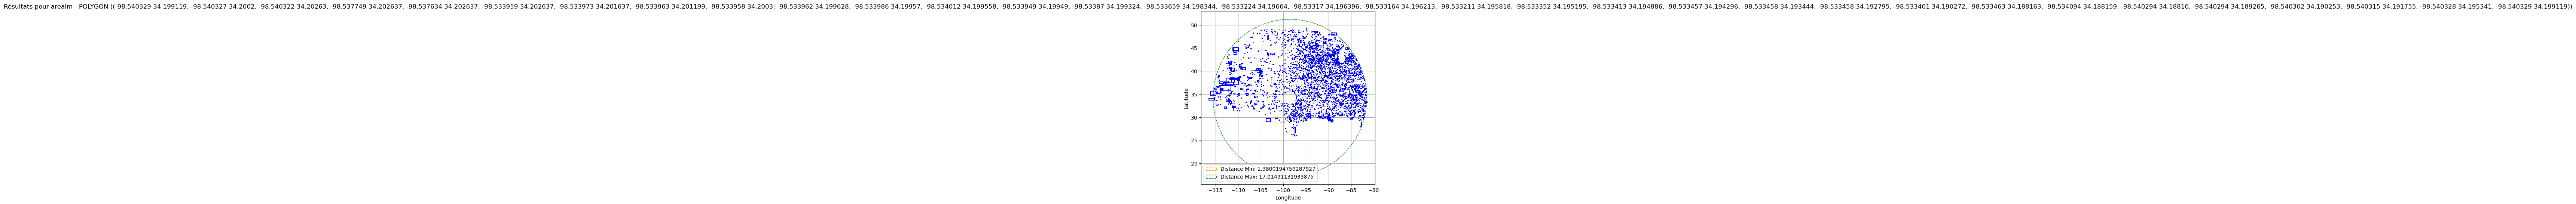

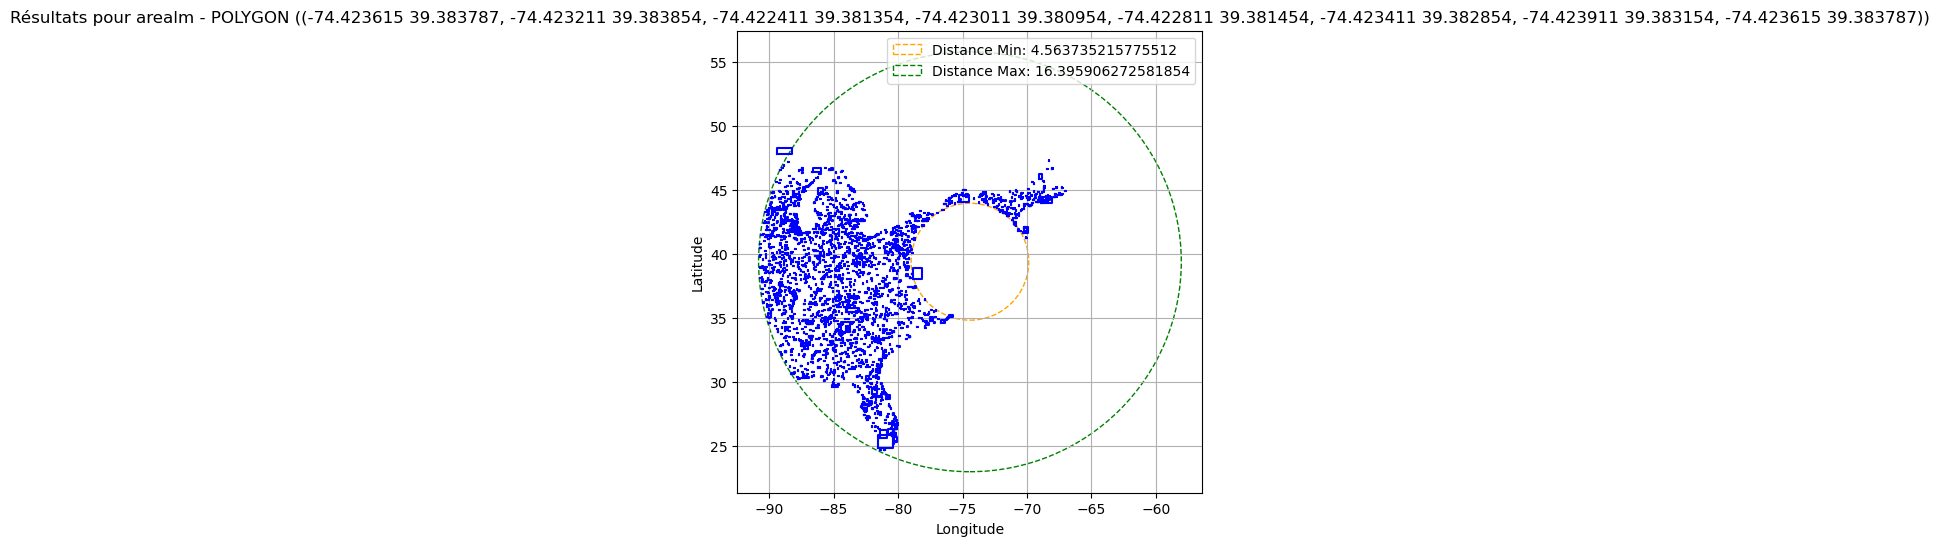

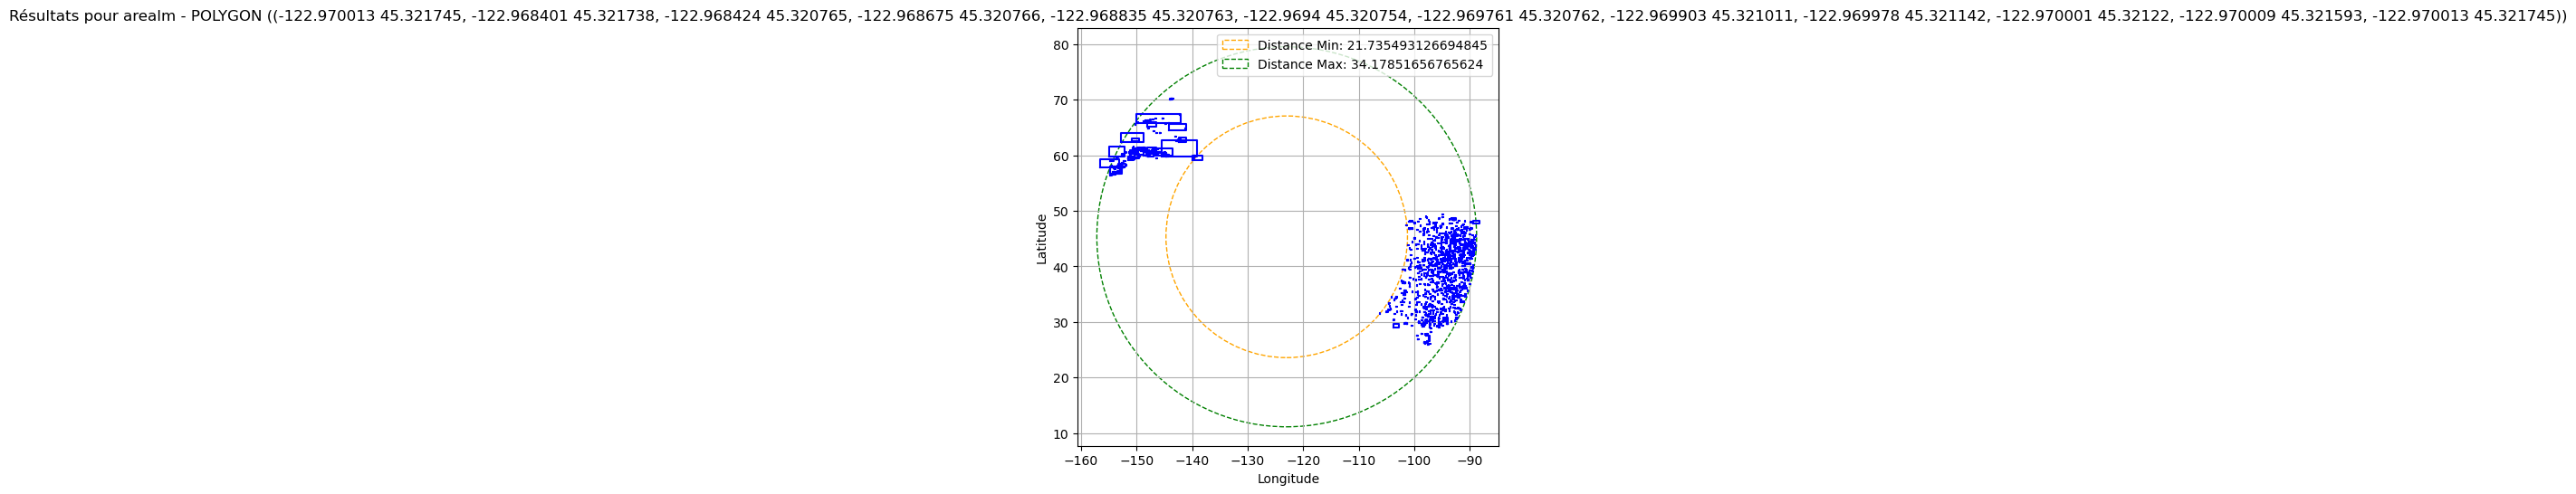

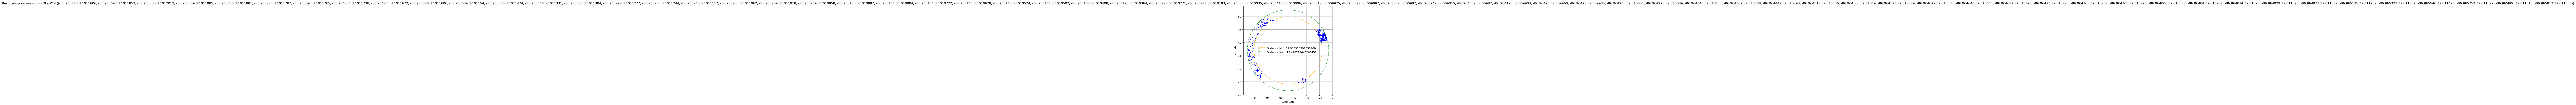

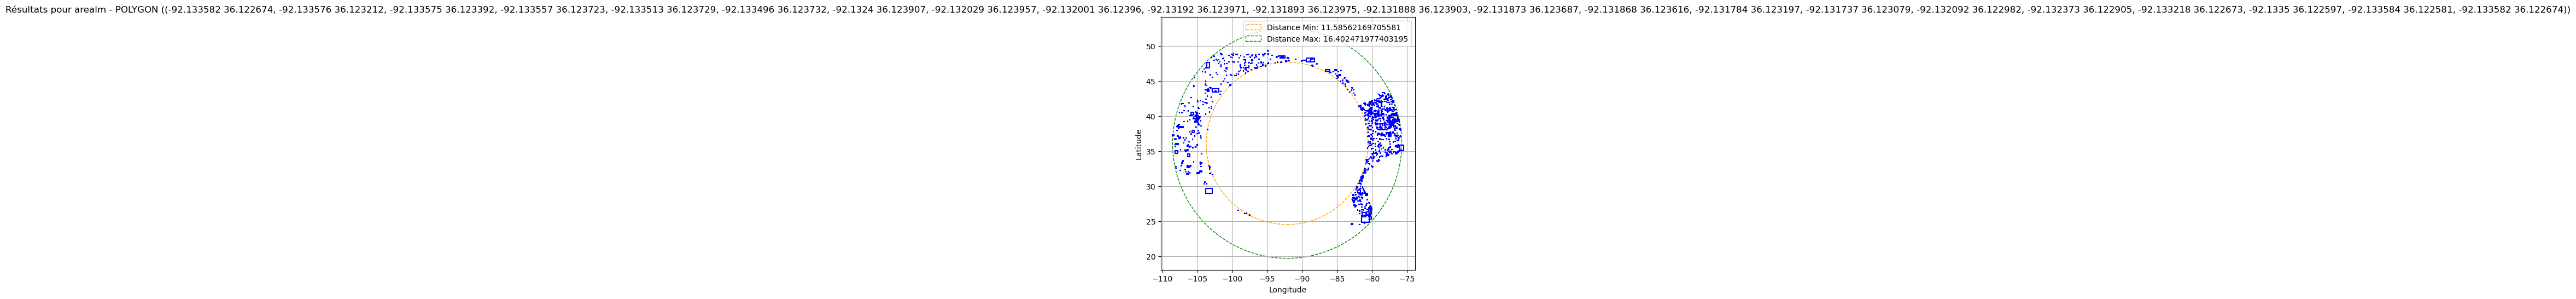

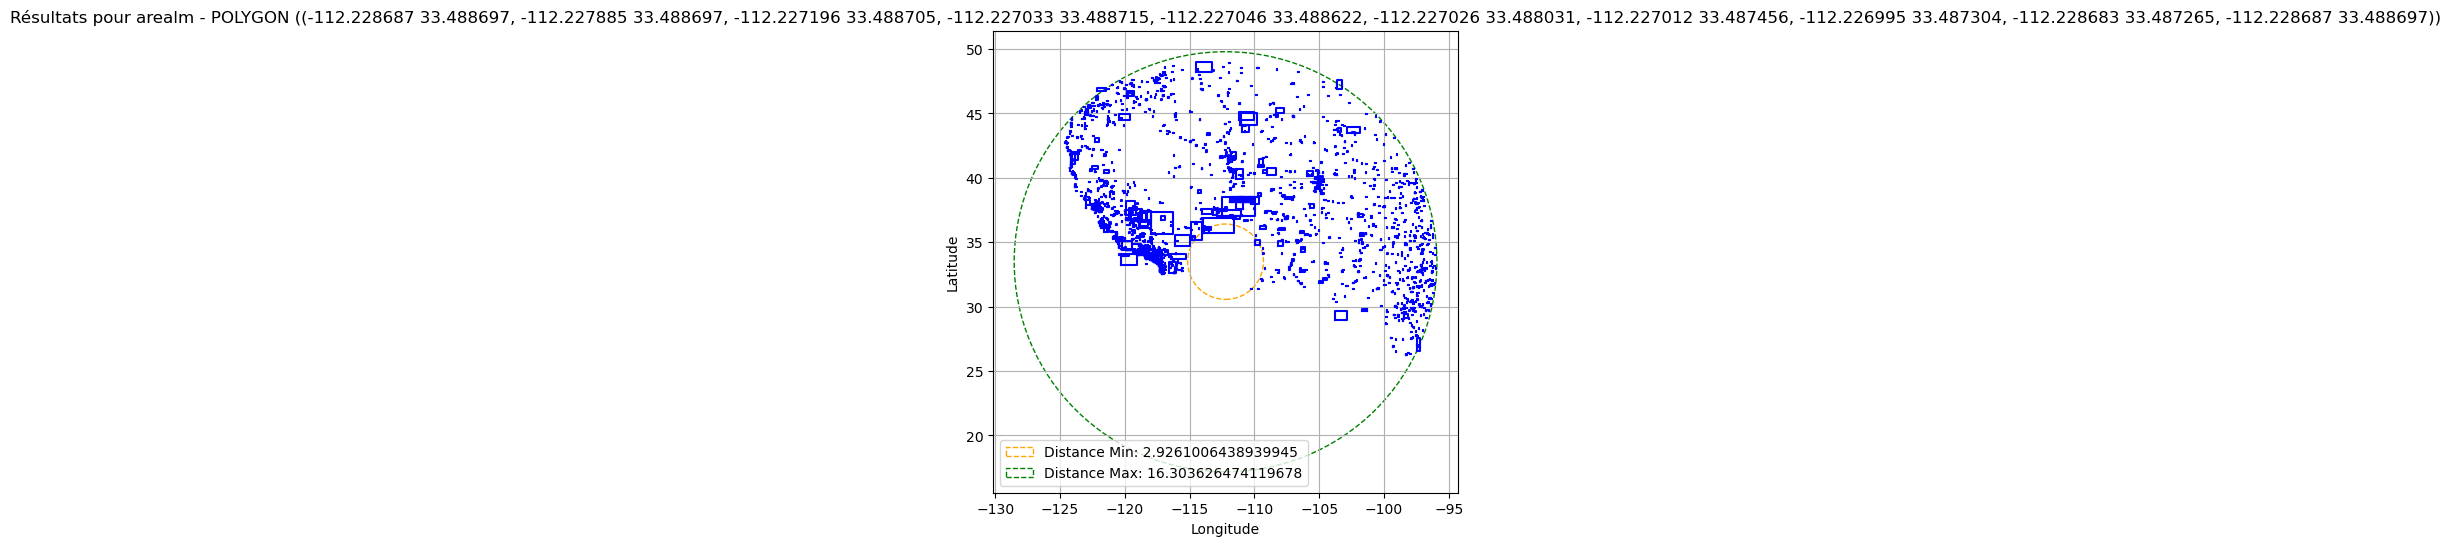

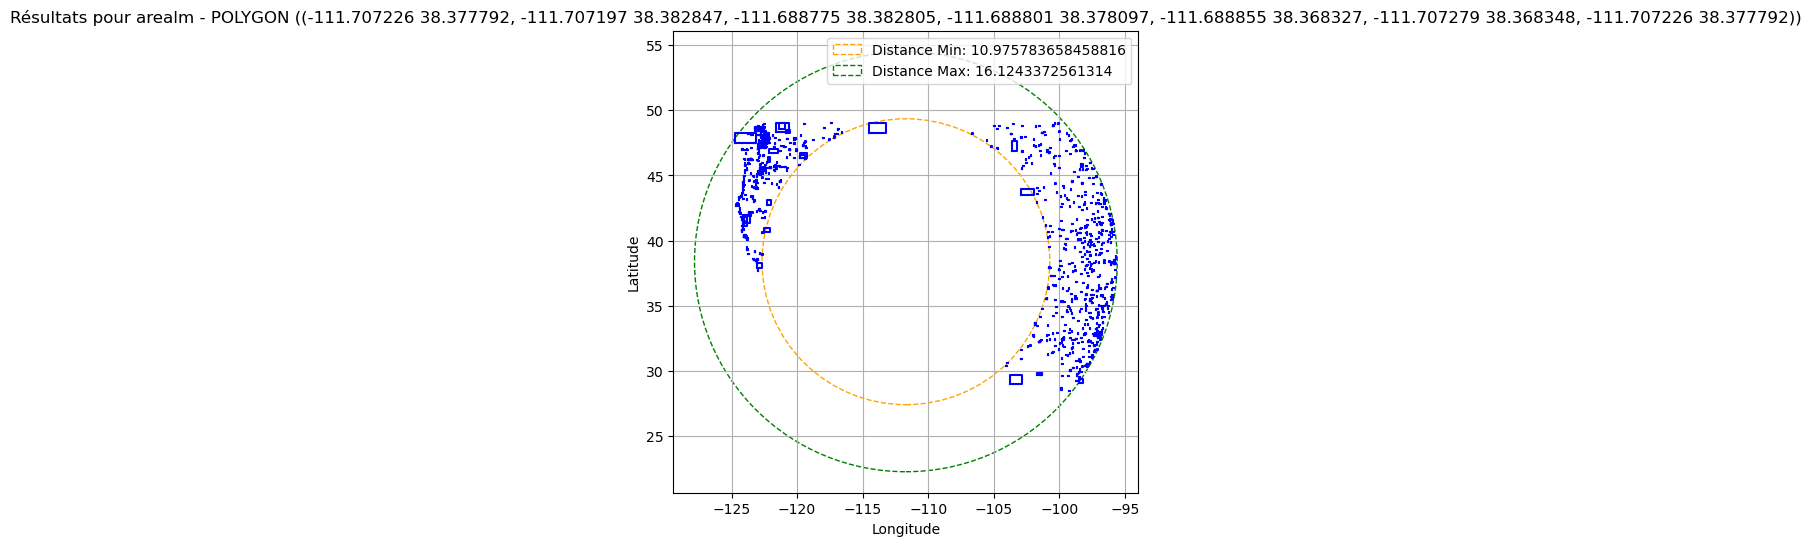

KeyboardInterrupt: 

In [ ]:
import os
import csv
import psycopg2
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Point, Polygon
from matplotlib.patches import Rectangle, Circle

# Charger la configuration de la base de données
def load_config(file_path="config.ini"):
    config = configparser.ConfigParser()
    config.read(file_path)
    return config

# Connexion à la base de données
def connect_db():
    config = load_config("config.ini")
    db_params = config["database"]
    return psycopg2.connect(
        dbname=db_params["dbname"],
        user=db_params["user"],
        password=db_params["password"],
        host=db_params["host"],
        port=db_params["port"],
    )

# Exécuter la requête et récupérer les géométries
def get_geometries(conn, table_name, geom_wkt, dist_min, dist_max):
    cursor = conn.cursor()

    # query = f"""
    #     SELECT ST_AsText(geometry)
    #     FROM {table_name}_mbr
    #     WHERE ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s)
    #     AND NOT ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s);
    # """
    
    query = f"""
        SELECT ST_AsText(geometry)
        FROM {table_name}_mbr
        WHERE ST_Intersects(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s))
        AND NOT ST_Within(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s));
    """
    # query = f"""
    #     SELECT ST_AsText(geometry)
    #     FROM {table_name}_mbr
    #     WHERE ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s)
    #     AND NOT ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s);
    # """
    
    # query = f"""
    #     SELECT ST_AsText(geometry)
    #     FROM {table_name}_mbr
    #     WHERE ST_Intersects(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s))
    #     AND NOT ST_Within(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s));
    # """

    # query = f"""
    #     SELECT ST_AsText(geometry)
    #     FROM {table_name}
    #     WHERE ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s)
    #     AND NOT ST_Within(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s));
    # """

    # query = f"""
    #     SELECT ST_AsText(geometry)
    #     FROM {table_name}
    #     WHERE ST_DWithin(geometry, ST_GeomFromText(%s, 4326), %s)
    #     AND NOT ST_Intersects(geometry, ST_Buffer(ST_GeomFromText(%s, 4326), %s));
    # """

    cursor.execute(query, (geom_wkt, dist_max, geom_wkt, dist_min))
    geometries = [row[0] for row in cursor.fetchall()]

    cursor.close()

    return geometries

# Afficher les formes sur un graphique
def plot_geometries(geometries, title, center_x, center_y, dist_min, dist_max, mbr=None):
    plt.figure(figsize=(6, 6))

    # Tracer les cercles pour dist_min et dist_max
    circle_min = Circle((center_x, center_y), dist_min, color='orange', fill=False, linestyle='--', label=f'Distance Min: {dist_min}')
    circle_max = Circle((center_x, center_y), dist_max, color='green', fill=False, linestyle='--', label=f'Distance Max: {dist_max}')
    
    plt.gca().add_patch(circle_min)
    plt.gca().add_patch(circle_max)

    if mbr:  # Si MBR est disponible, le dessiner
        minx, miny, maxx, maxy = mbr
        rectangle = Rectangle((minx, miny), maxx - minx, maxy - miny, linewidth=2, edgecolor='red', fill=False)
        plt.gca().add_patch(rectangle)

    # Tracer les géométries récupérées de la base de données
    for geom_wkt in geometries:
        shape = loads(geom_wkt)  # Convertir WKT en objet Shapely
        if shape.geom_type == "Point":
            plt.plot(shape.x, shape.y, "ro")  # Afficher en rouge les points
        elif shape.geom_type == "Polygon":
            x, y = shape.exterior.xy
            plt.plot(x, y, "b-")  # Tracer les contours en bleu

    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()  # Ajouter une légende pour les cercles
    plt.show()

# Traitement et affichage des résultats
def process_and_plot(dataset_input):
    if not os.path.exists(dataset_input):
        print(f"Erreur : le chemin '{dataset_input}' n'existe pas.")
        return

    dataset_files = (
        [f for f in os.listdir(dataset_input) if f.endswith("_dataset.csv")]
        if os.path.isdir(dataset_input)
        else [dataset_input] if dataset_input.endswith("_dataset.csv") else []
    )

    if not dataset_files:
        print("Aucun fichier '_dataset.csv' trouvé.")
        return

    # Connexion à la base de données
    conn = connect_db()

    for dataset_file in dataset_files:
        dataset_path = os.path.join(dataset_input, dataset_file) if os.path.isdir(dataset_input) else dataset_file
        table_name = os.path.basename(dataset_file).replace("_dataset.csv", "")
        print(f"Traitement du fichier : {dataset_path}, table : {table_name}")

        # Lire le fichier CSV ligne par ligne
        with open(dataset_path, mode="r", encoding="utf-8") as dataset:
            reader = csv.DictReader(dataset)
            for row in reader:
                object_mbr = row["MBR"]
                object_true_shape = row["Spatial Object"]
                dist_min = float(row["Distance Min"])
                dist_max = float(row["Distance Max"])

                # Convertir MBR en un tuple de coordonnées
                mbr_coords = tuple(map(float, object_mbr.strip("()").split(", "))) if object_mbr else None

                # Traiter la géométrie du vrai objet (true shape)
                shape = loads(object_true_shape)  # Convertir WKT en un objet Shapely

                # Centre des cercles pour dist_min et dist_max (on peut utiliser le centroid si c'est un polygon)
                if shape.geom_type == "Point":
                    center_x, center_y = shape.x, shape.y
                else:  # Polygon
                    center_x, center_y = shape.centroid.x, shape.centroid.y

                # Récupérer les géométries à partir de la base de données
                geometries = get_geometries(conn, table_name, object_true_shape, dist_min, dist_max)

                # Tracer la géométrie et les cercles
                title = f"Résultats pour {table_name} - {object_true_shape}"
                plot_geometries(geometries, title, center_x, center_y, dist_min, dist_max, mbr_coords)

    conn.close()

if __name__ == "__main__":
    dataset_input = "arealm_dataset.csv"  # Remplacez par votre propre chemin
    process_and_plot(dataset_input)
